In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import pystan
import arviz

import sys

sys.path.append("../")
from src.preprocess_data import (
    create_df,
)

from src.utils import print_results, get_class_probs, get_stan_model

In [2]:
df = create_df("../../data/games.csv")

train = df.loc[df["date"] < "2019-01-01"]
test = df.loc[df["date"] >= "2019-01-01"]

In [3]:
model_dir = Path("../../stan_models/")
model_sym_name = "ordered_logistic_elo_diff_symmetry"
model_name = "ordered_logistic_elo_diff"

load_symmetric_model = True
load_model = True

In [4]:
model_sym = get_stan_model(model_dir, model_sym_name, load_symmetric_model)
model = get_stan_model(model_dir, model_name, load_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d79412a633a291c9db00ee5702555b23 NOW.


No compiled model, re-compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_40064f13a4ffc02b53f3229cca0e4452 NOW.


No compiled model, re-compiling


In [5]:
stan_data = {
    "num_games": len(train),
    "p1_elo_diff_p2": train["p1_elo_diff_p2_scaled"].values,
    "player_1_white": train["p1_white"].values.astype(int),
    "fit_model": 1,
    "y": train["p1_outcome"].values,
    # Predict on test set:
    "predict_on_test_set": 1,
    "num_test_games": len(test),
    "p1_elo_diff_p2_test": test["p1_elo_diff_p2_scaled"].values,
    "p1_test_white": test["p1_white"].values.astype(int),
}

In [6]:
fit_sym = model_sym.sampling(data=stan_data)
fit = model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


### Two cutpoints

In [7]:
params = fit.extract(permuted=True)

inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data).reset_index().rename(columns={"index": "parameter"})
)

In [8]:
summary_df.head(5)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,e,3.028,0.204,2.648,3.411,0.004,0.003,3321.0,3282.0,3344.0,2826.0,1.0
1,w,0.726,0.096,0.546,0.908,0.002,0.001,2864.0,2852.0,2867.0,2694.0,1.0
2,c[0],-0.906,0.075,-1.057,-0.774,0.001,0.001,2594.0,2560.0,2597.0,2371.0,1.0
3,c[1],1.697,0.083,1.545,1.856,0.001,0.001,3272.0,3266.0,3280.0,2971.0,1.0
4,ypred[0],1.076,0.286,1.000,2.000,0.004,0.003,4149.0,4118.0,4176.0,4059.0,1.0


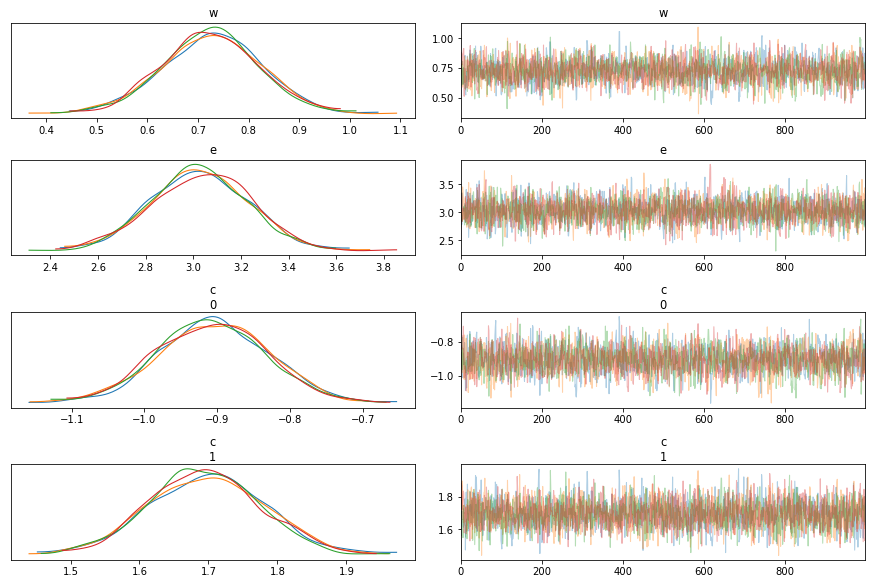

In [24]:
arviz.plot_trace(inference_data, var_names=["w", "e", "c"], compact=False);

In [25]:
train_cls_probs = get_class_probs(params, "ypred")
cls_pred = np.argmax(train_cls_probs, 1) + 1
print_results(train, cls_pred, "Train", dp=4)

Train - exact: 0.5483, out by one: 0.4464, out by two: 0.0053


In [26]:
test_cls_probs = get_class_probs(params, "ypred_test")
cls_pred_test = np.argmax(test_cls_probs, 1) + 1
print_results(test, cls_pred_test, "Test", dp=4)

Test - exact: 0.5497, out by one: 0.4411, out by two: 0.0092


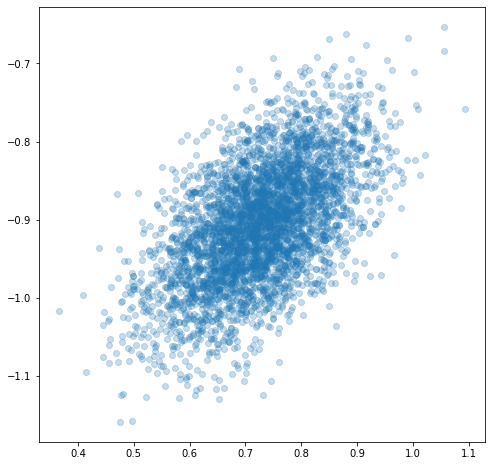

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(params["w"], params["c"][:, 0], alpha=0.25);

### Symmetric

In [28]:
params_sym = fit_sym.extract(permuted=True)

inference_data_sym = arviz.convert_to_inference_data(fit_sym)
summary_df_sym = (
    arviz.summary(inference_data_sym)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

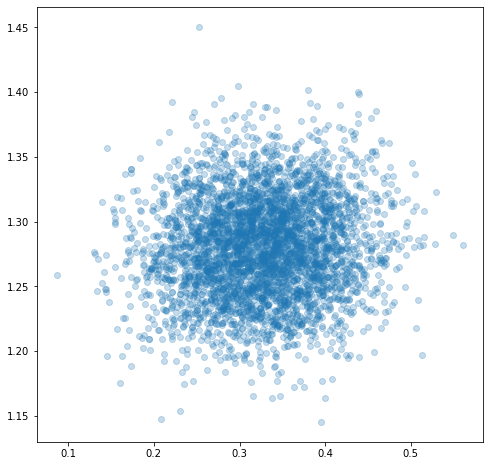

In [29]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(params_sym["w"], params_sym["c_raw"], alpha=0.25);

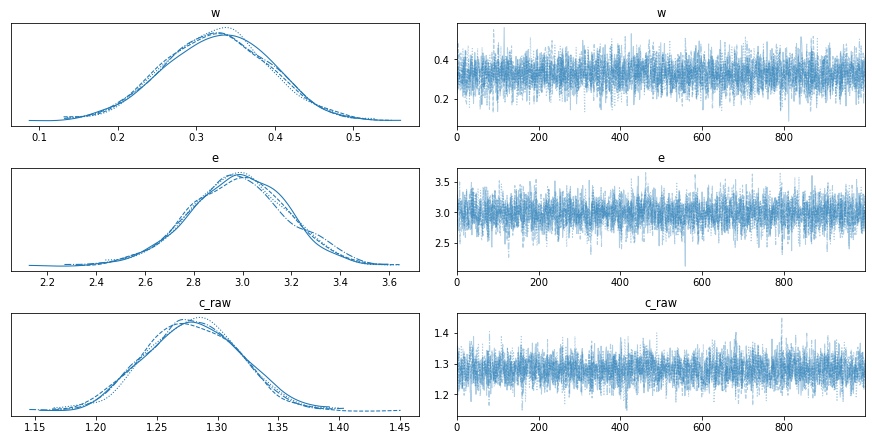

In [30]:
arviz.plot_trace(inference_data_sym, var_names=["w", "e", "c_raw"]);

In [31]:
train_cls_probs_sym = get_class_probs(params_sym, "ypred")
cls_pred_sym = np.argmax(train_cls_probs_sym, 1) + 1
print_results(train, cls_pred_sym, "Train", dp=4)

Train - exact: 0.5376, out by one: 0.4576, out by two: 0.0047


In [32]:
test_cls_probs_sym = get_class_probs(params_sym, "ypred_test")
cls_pred_test_sym = np.argmax(test_cls_probs_sym, 1) + 1
print_results(test, cls_pred_test_sym, "Test", dp=4)

Test - exact: 0.5635, out by one: 0.4365, out by two: 0.0000


### Comparison

For player 1 playing a player of the same elo rating:

\begin{align}
P_{\text{win}} &= \text{logit}^{-1}(w - c_1) \\
P_{\text{draw}} &= \text{logit}^{-1}(w - c_0) - \sigma^{-1}(w - c_1)\\
P_{\text{lose}} &= 1 - \text{logit}^{-1}(w - c_0)
\end{align}

In [33]:
def calculate_outcome_probs(params, elo_diff=0, verbose=True, override_w=False):
    inv_logit = lambda x: 1 / (1 + np.exp(-x))
    w = params["w"].mean() if not override_w else 0
    e = params["e"].mean()
    c0 = params["c"][:, 0].mean()
    c1 = params["c"][:, 1].mean()

    prob_win = inv_logit(w - c1 + e * elo_diff)
    prob_draw = inv_logit(w - c0 + e * elo_diff) - inv_logit(w - c1 + e * elo_diff)
    prob_lose = 1 - inv_logit(w - c0 + e * elo_diff)
    if verbose:
        print(
            f"Prob - win: {prob_win:.4f}, draw: {prob_draw:.4f}, lose: {prob_lose:.4f}"
        )
    return prob_win, prob_draw, prob_lose

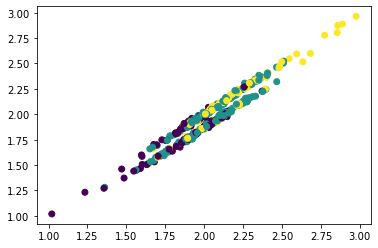

In [35]:
plt.scatter(
    params_sym["ypred_test"].mean(0),
    params["ypred_test"].mean(0),
    c=test["p1_outcome"].values,
);

In [36]:
_ = calculate_outcome_probs(params)

Prob - win: 0.2747, draw: 0.5617, lose: 0.1636


In [37]:
_ = calculate_outcome_probs(params_sym)

Prob - win: 0.2781, draw: 0.5548, lose: 0.1671


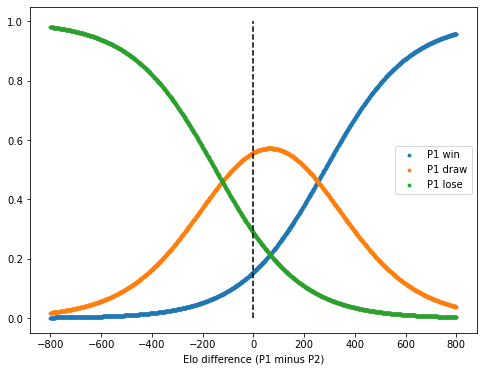

In [38]:
ed = np.linspace(-800, 800, 1000)

pw, pd, pl = calculate_outcome_probs(
    params, elo_diff=ed / 500, verbose=False, override_w=True
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(ed, pw, s=8, label="P1 win")
ax.scatter(ed, pd, s=8, label="P1 draw")
ax.scatter(ed, pl, s=8, label="P1 lose")
ax.vlines(0, ymin=0, ymax=1, linestyle="--")
ax.legend()
ax.set_xlabel("Elo difference (P1 minus P2)");

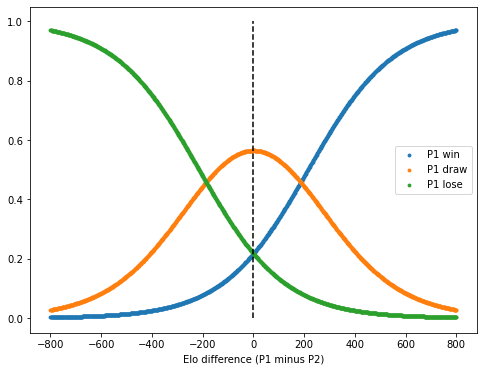

In [39]:
ed = np.linspace(-800, 800, 1000)

pw, pd, pl = calculate_outcome_probs(
    params_sym, elo_diff=ed / 500, verbose=False, override_w=True
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(ed, pw, s=8, label="P1 win")
ax.scatter(ed, pd, s=8, label="P1 draw")
ax.scatter(ed, pl, s=8, label="P1 lose")
ax.vlines(0, ymin=0, ymax=1, linestyle="--")
ax.legend()
ax.set_xlabel("Elo difference (P1 minus P2)");